##### 1.1

Based on word2vec embeddings you have downloaded, use cosine similarity to find the most similar
word to each of these words: (a) “student”; (b) “Apple”; (c) “apple”. Report the most similar word
and its cosine similarity.

In [1]:
import gensim.downloader

word2vec = gensim.downloader.load('word2vec-google-news-300')

In [2]:
# Query the vector of any word by specifying the word as the key
# most_similar function uses cosine similarity as documented

similar_student = word2vec.most_similar('student', topn=1)
print("Most similar word to 'student': {} with cosine similarity score {}".format(similar_student[0][0], similar_student[0][1]))

# (b) Find the most similar word to "Apple"
similar_Apple = word2vec.most_similar('Apple', topn=1)
print("Most similar word to 'Apple': {} with cosine similarity score {}".format(similar_Apple[0][0], similar_Apple[0][1]))

# (c) Find the most similar word to "apple"
similar_apple = word2vec.most_similar('apple', topn=1)
print("Most similar word to 'apple': {} with cosine similarity score {}".format(similar_apple[0][0], similar_apple[0][1]))

Most similar word to 'student': students with cosine similarity score 0.7294867038726807
Most similar word to 'Apple': Apple_AAPL with cosine similarity score 0.7456984519958496
Most similar word to 'apple': apples with cosine similarity score 0.720359742641449


##### 1.2a

Describe the size (number of sentences) of the training, development and test file for CoNLL2003.
Specify the complete set of all possible word labels based on the tagging scheme (IO, BIO,
etc.) you chose.


For the Named Entity Recognition task, the information present in numerical digits does not help in predicting the entity. So, we replace all the digits by 0. So, now the model can concentrate on more important alphabets

In [2]:
import codecs
import re

def zero_digits(s):
    # Replace every digit in a string by a zero.

    return re.sub('\d', '0', s)

def load_sentences(path, zeros):
    
    # Load sentences. A line must contain at least a word and its tag.
    # Sentences are separated by empty lines.
    # Ignore lines with -DOCSTART- -X- -X- O only
    
    sentences = []
    sentence = []
    for line in codecs.open(path, 'r', 'utf8'):
        line = zero_digits(line.rstrip()) if zeros else line.rstrip()
        if not line:
            if len(sentence) > 0:
                if 'DOCSTART' not in sentence[0][0]:
                    sentences.append(sentence)
                sentence = []
        else:
            word = line.split()
            assert len(word) >= 2
            sentence.append(word)
    if len(sentence) > 0:
        if 'DOCSTART' not in sentence[0][0]:
            sentences.append(sentence)
    return sentences

train = load_sentences('./dataset/eng.train', True)
testa = load_sentences('./dataset/eng.testa', True)
testb = load_sentences('./dataset/eng.testb', True)

In [3]:
def get_sentence(data):
    sentences, ner = [], []
    for sentence in data:
        current_sentence = []
        current_ner = []
        
        for line in sentence:
            current_sentence.append(line[0])
            current_ner.append(line[-1])
            
        sentences.append(current_sentence)
        ner.append(current_ner)
        
    return sentences, ner

train_sentence, train_parts = get_sentence(train)
testa_sentence, testa_parts = get_sentence(testa)
testb_sentence, testb_parts = get_sentence(testb)

In [4]:
print("----- Number of sentences -----")
print("Training:", len(train_sentence))
print("Development:", len(testa_sentence))
print("Testing:", len(testb_sentence))

----- Number of sentences -----
Training: 14041
Development: 3250
Testing: 3453


In [5]:
train_tags = [tag for sublist in train_parts for tag in sublist]
testa_tags = [tag for sublist in testa_parts for tag in sublist]
testb_tags = [tag for sublist in testb_parts for tag in sublist]
set(train_tags), set(testa_tags), set(testb_tags)

({'B-LOC', 'B-MISC', 'B-ORG', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O'},
 {'B-MISC', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O'},
 {'B-LOC', 'B-MISC', 'B-ORG', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O'})

Our chosen tagging scheme is IOB1

- I-ORG: Inside of an organization's name (for multi-word names).
- O: Outside of any named entity (non-entity word).
- I-MISC: Inside of a miscellaneous entity name (for multi-word names).
- I-PER: Inside of a person's name (for multi-word names).
- I-LOC: Inside of a location's name (for multi-word names).
- B-LOC: Beginning of a location's name.
- B-MISC: Beginning of a miscellaneous entity name.
- B-ORG: Beginning of an organization's name.



##### 1.2b

Choose an example sentence from the training set of CoNLL2003 that has at least two named
entities with more than one word. Explain how to form complete named entities from the label
for each word, and list all the named entities in this sentence.

In [8]:
print("108th Entry in the training set is: \n")
print("Sentence:",' '.join(train_sentence[107]))
print()
print("Labels:", ' '.join(train_parts[107]))

108th Entry in the training set is: 

Sentence: Tension has mounted since Israeli Prime Minister Benjamin Netanyahu took office in June vowing to retain the Golan Heights Israel captured from Syria in the 0000 Middle East war .

Labels: O O O O I-MISC O O I-PER I-PER O O O O O O O O I-LOC I-LOC B-LOC O O I-LOC O O O I-LOC I-LOC O O


<b>The sentence above contains the named entities "Benjamin Netanyahu", "Golan Heights", "Israel", "Syria", "Middle East"</b>

Named entities with more than 1 word can be identified by consecutive 'I-TYPE' tags, where TYPE is one of MISC, LOC, PER, ORG.
The chunk for the multi-word named entity terminates when the next tag is not of the same tag.

For instance, in the example sentence, we can identify *Benjamin Netanyahu* as a named entity because the words *Benjamin* and *Netanyahu* are both tagged with I-PER and the next word *took* is tagged with O.

We can also identify *Golan Heights* as a named entity because the words *Golan* and *Heights* are both tagged with I-LOC but the next word *Israel* is tagged with B-LOC.

As an additional note, we identify *Israel* as a named entity because the next word *captured* is tagged with O. If instead, the following word were something that formed a named entity with *Israel* (eg. Radio), then the tag for that word would be I-LOC.

##### 1.3a

Discuss how you deal with new words in the training set which are not found in the pretrained
dictionary. Likewise, how do you deal with new words in the test set which are not found in
either the pretrained dictionary or the training set? Show the corresponding code snippet.

In [9]:
import keras

from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.initializers import Constant

from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

from seqeval.metrics import f1_score, classification_report

import seaborn as sns
import numpy as np
import pandas as pd

from time import perf_counter

In [10]:
labelSet = set()
wordSet = set()

for data in train_sentence:
    for labeled_text in data:
        wordSet.add(labeled_text)

for data in train_parts:
    for labeled_text in data:
        labelSet.add(labeled_text)

In [11]:
# Sort the set to ensure '0' is assigned to 0
sorted_labels = sorted(list(labelSet), key=len)
# Create mapping for labels
label2Idx = {}
for label in sorted_labels:
    label2Idx[label] = len(label2Idx)
idx2Label = {v: k for k, v in label2Idx.items()}

# Create mapping for words
word2Idx = {}
if len(word2Idx) == 0:
    word2Idx["PADDING_TOKEN"] = len(word2Idx)
    word2Idx["UNKNOWN_TOKEN"] = len(word2Idx)
for word in wordSet:
    word2Idx[word] = len(word2Idx)

In [12]:
# Converting our words into its indexes
def createMatrices(sentence, labels, word2Idx, label2Idx):
    sentences = []
    final_labels = []
    
    for text in sentence:
        wordIndices = []
        
        for word in text:
            if word in word2Idx:
                wordIdx = word2Idx[word]
            else:
                wordIdx = word2Idx["UNKNOWN_TOKEN"]
                
            wordIndices.append(wordIdx)
        sentences.append(wordIndices)
        
    for label in labels:
        labelIndices = []
        
        for lab in label:
            labelIndices.append(label2Idx[lab])
        final_labels.append(labelIndices)
        
    return sentences, final_labels

In [13]:
train_sentences, train_labels = createMatrices(train_sentence, train_parts, word2Idx, label2Idx)
valid_sentences, valid_labels = createMatrices(testa_sentence, testa_parts, word2Idx, label2Idx)
test_sentences, test_labels = createMatrices(testb_sentence, testb_parts, word2Idx, label2Idx)


Max Sentence Length: 113
Mean Sentence Length: 14
90% Quartile Length: 37.0



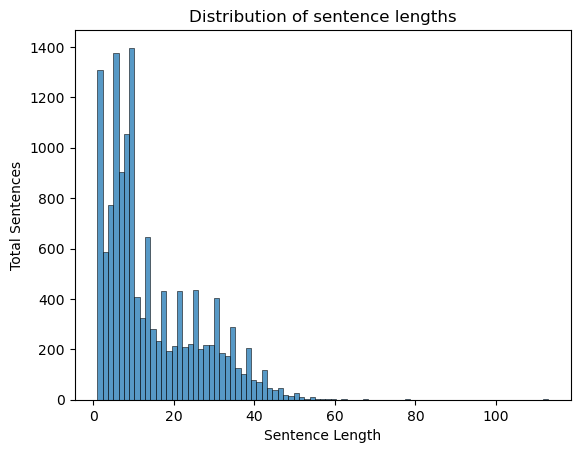

In [14]:
sentence_lengths = [len(sentence) for sentence in train_sentences]

ax = sns.histplot(sentence_lengths)
ax.set(xlabel='Sentence Length',
       ylabel='Total Sentences',
       title='Distribution of sentence lengths')

print(f"""
Max Sentence Length: {max(sentence_lengths)}
Mean Sentence Length: {sum(sentence_lengths)//len(sentence_lengths)}
90% Quartile Length: {np.quantile(sentence_lengths, 0.95)}
""")

In [15]:
embedding_matrix = np.zeros((len(word2Idx), word2vec.vector_size))
miss_counter = 0
for word, i in word2Idx.items():
    print
    try:
        embedding_vector = word2vec[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except KeyError:
        miss_counter += 1
        continue
        
print(f'words missed: {miss_counter}')

words missed: 2446


In [16]:
def padding(sentences, labels, max_len, padding='post'):
    padded_sentences = pad_sequences(sentences, max_len, padding='post')
    padded_labels = pad_sequences(labels, max_len, padding='post')
    return padded_sentences, padded_labels

def get_train_val_test_data(train_sentences, valid_sentences, test_sentences, train_labels, valid_labels, test_labels, seq_len=50):
    train_features, train_labels = padding(train_sentences, train_labels, seq_len, padding='post' )
    valid_features, valid_labels = padding(valid_sentences, valid_labels, seq_len, padding='post' )
    test_features, test_labels = padding(test_sentences, test_labels, seq_len, padding='post' )
    
    train_label_encoded = [to_categorical(labels, num_classes=len(idx2Label)) for labels in train_labels]
    valid_label_encoded = [to_categorical(labels, num_classes=len(idx2Label)) for labels in valid_labels]
    test_label_encoded = [to_categorical(labels, num_classes=len(idx2Label)) for labels in test_labels]
    
    return train_features, train_label_encoded, valid_features, valid_label_encoded, test_features, test_label_encoded

In [17]:
# We set the max_seq_len to be 50 as a good compromise between training times
# and sentence representation. As observed in the plot above, 95% of sentences
# actually have lengths below 37.
max_seq_len = 50

In [18]:
(train_features, train_label_encoded, valid_features, 
 valid_label_encoded, test_features, test_label_encoded) = get_train_val_test_data(train_sentences, 
                                                                                    valid_sentences, 
                                                                                    test_sentences,
                                                                                    train_labels, 
                                                                                    valid_labels, 
                                                                                    test_labels, 
                                                                                    seq_len=max_seq_len)


##### 1.3b


Describe what neural network you used to produce the final vector representation of each
word and what are the mathematical functions used for the forward computation (i.e., from
the pretrained word vectors to the final label of each word). Give the detailed setting of the
network including which parameters are being updated, what are their sizes, and what is the
length of the final vector representation of each word to be fed to the softmax classifier.

In [19]:
def cal_f1(model, feautures, labels, labels_encoded):
    '''
    Computes the SeqEval F1 Score
    '''
    pred = model.predict(feautures, verbose=False)
    y_pred = []
    y_true = []

    reverse_mapping = dict(zip(label2Idx.values(), label2Idx.keys()))
    for i in range(len(labels)):
        gt = [reverse_mapping[encoded] for encoded in np.argmax(labels_encoded[i], axis=1)]
        pd = [reverse_mapping[encoded] for encoded in np.argmax(pred[i], axis=1)]

        assert len(gt) == len(pd), f"{i} index unequal"

        y_true.append(gt)

        y_pred.append(pd)
    
    
    f1 = f1_score(y_true, y_pred)
    return f1

In [24]:
def create_model(max_seq_len, n_voc, embedding_matrix, num_classes, hidden1=64, hidden2=32):
    '''
    Function to generate our Model. We chose a Bi-Directional LSTM with multiple layers. A non-linear Dense Layer is added before the output layer to smoothen the values
    '''
    optimizer = Adam(learning_rate=0.001, beta_1=0.95, beta_2=0.90)

    
    word_input = Input(shape=(max_seq_len,))
    #embedding layer
    word_emb = Embedding(n_voc,
                        300,
                        weights=[embedding_matrix],
                        trainable=False,
                        mask_zero=True
                        )(word_input)
    
    # We set recurrent dropout to 0 to use cuDNN kernels for faster training
    blstm_out_1 = Bidirectional(LSTM(units=hidden1, 
                                     return_sequences=True, 
                                     recurrent_dropout=0.0, 
                                     dropout=0.5
                                     ))(word_emb)
    blstm_out_1 = BatchNormalization()(blstm_out_1)
    
    blstm_out_2 = Bidirectional(LSTM(units=hidden2, 
                                     return_sequences=True, 
                                     recurrent_dropout=0.0, 
                                     dropout=0.2
                                     ))(blstm_out_1)
    blstm_out_2 = BatchNormalization()(blstm_out_2)
    
    dense_out = Dense(64, activation="relu")(blstm_out_2)
    dense_out = Dropout(0.5)(dense_out)  # Optional: Dropout for regularization
    
    out = TimeDistributed(Dense(num_classes, activation="softmax"))(dense_out)

    model = Model(word_input, out)

    model.compile(optimizer=optimizer, loss="categorical_crossentropy")

    
    return model



In [25]:
model = create_model(max_seq_len, len(word2Idx), embedding_matrix, len(label2Idx), 128, 64)

In [26]:
epochs = 50
patience_limit = 10

In [27]:
histories = {
    'epochs': [],
    'loss': [],
    'val_loss': [],
    'train_f1': [],
    'val_f1': []
}

f1_max = -1
patience = 0

t1 = perf_counter()

# Training Loop
for epoch in range(epochs):
    history = model.fit(train_features, np.array(train_label_encoded),
                        epochs=1, batch_size=64,
                        validation_data=(valid_features, np.array(valid_label_encoded)),
                       )
    
    
    train_f1 = cal_f1(model, train_features, train_labels, train_label_encoded)
    val_f1 = cal_f1(model, valid_features, valid_labels, valid_label_encoded)
    
    histories['epochs'].append(epoch+1)
    histories['loss'].append(history.history['loss'][0])
    histories['val_loss'].append(history.history['val_loss'][0])
    histories['train_f1'].append(train_f1)
    histories['val_f1'].append(val_f1)
    
    print(f"Epoch {epoch+1}/50: ", end="")
    print(f"Train F1: {train_f1}   Val F1: {val_f1}")
    
    # Save the model with the best development F1 Score
    if val_f1 > f1_max:
        model.save("./model/best_model.h5")
        f1_max = val_f1
        patience = 0
    else:
        patience += 1
    
    if patience == patience_limit:
        print("Ending Early")
        break
        
t2 = perf_counter()

220/220 [==============================] - 105s 402ms/step - loss: 0.4415 - val_loss: 0.3905
Epoch 1/50: Train F1: 0.24201646231087123   Val F1: 0.2074854134054362


C:\Users\yihao\anaconda3\envs\tf_gpu\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


220/220 [==============================] - 83s 376ms/step - loss: 0.1467 - val_loss: 0.1809
Epoch 2/50: Train F1: 0.8349210491974423   Val F1: 0.7313886077114199
220/220 [==============================] - 93s 422ms/step - loss: 0.1186 - val_loss: 0.1727
Epoch 3/50: Train F1: 0.8742719074944989   Val F1: 0.7757851615839783
220/220 [==============================] - 92s 419ms/step - loss: 0.1032 - val_loss: 0.1472
Epoch 4/50: Train F1: 0.8903832932279133   Val F1: 0.791470054446461
220/220 [==============================] - 93s 422ms/step - loss: 0.0928 - val_loss: 0.1507
Epoch 5/50: Train F1: 0.9009133504631529   Val F1: 0.8105253573704816
220/220 [==============================] - 93s 424ms/step - loss: 0.0842 - val_loss: 0.1418
Epoch 6/50: Train F1: 0.9129937158528949   Val F1: 0.8126196772134586
220/220 [==============================] - 103s 470ms/step - loss: 0.0784 - val_loss: 0.1432
Epoch 7/50: Train F1: 0.9217755335448092   Val F1: 0.8155304411228581
220/220 [===================

##### 1.3c


Report how many epochs you used for training, as well as the running time.

In [28]:
print(f"""
Total Epochs: {epoch+1}
Total Training Time: {round(t2-t1, 3)}sec
""")

# We will report the number of epochs used in training after EarlyStopper triggered. Although the original intended epoch value was 50


Total Epochs: 47
Total Training Time: 6879.946sec



##### 1.3d


Report the f1 score on the test set, as well as the f1 score on the development set for each
epoch during training.

##### Test Set

In [38]:
model = keras.models.load_model('./model/best_model.h5')

pred = model.predict(test_features)

108/108 [==============================] - 8s 28ms/step


In [38]:
model = keras.models.load_model('./model/best_model.h5')

pred = model.predict(test_features)

108/108 [==============================] - 8s 28ms/step


In [39]:
y_pred = []
y_true = []

reverse_mapping = dict(zip(label2Idx.values(), label2Idx.keys()))

for i in range(len(test_labels)):
    gt = [reverse_mapping[encoded] for encoded in np.argmax(test_label_encoded[i], axis=1)]
    pd = [reverse_mapping[encoded] for encoded in np.argmax(pred[i], axis=1)]
    
    assert len(gt) == len(pd), f"{i} index unequal"
    
    y_true.append(gt)
    
    y_pred.append(pd)

In [40]:
# Display the seqeval F1 score on the test set
f1_score(y_true, y_pred)

0.7600075886928476

In [41]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         LOC       0.87      0.83      0.85      1653
        MISC       0.75      0.68      0.71       701
         ORG       0.79      0.67      0.72      1657
         PER       0.78      0.67      0.72      1580

   micro avg       0.81      0.72      0.76      5591
   macro avg       0.80      0.71      0.75      5591
weighted avg       0.81      0.72      0.76      5591



##### Development set training results at each Epoch (F1)

In [42]:
import pandas as pd

df = pd.DataFrame(histories)

df[['epochs', 'val_f1']]

,epochs,val_f1
0,1,0.207485
1,2,0.731389
2,3,0.775785
3,4,0.791470
4,5,0.810525
5,6,0.812620
6,7,0.815530
7,8,0.815661
8,9,0.827038
9,10,0.831934
